<a href="https://colab.research.google.com/github/aradgast/DeepLearningCourse/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 4 - Variational Autoencoders**

In this assignment, we will train a model to produce new human faces with variational autoencoders (VAEs). 
Variational autoencoders let us design complex generative models of data, and fit them to large datasets. They can generate images of fictional celebrity faces (as we'll do in this assignment), high-resolution digital artwork and many more tasks. These models also yield state-of-the-art machine learning results in image generation and reinforcement learning. Variational autoencoders (VAEs) were defined in 2013 by Kingma and Wellings [1].

In this assignment, you will build, train and analyze a VAE with the CelebA dataset. You will analyze how well images can be reconstructed from the lower dimensional representations and try to generate images that look similar to the images in the CelebA dataset.

[1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013). 


# **Section 1: Variational Autoencoders**


Let us recall the structure of the variational autoencoder:

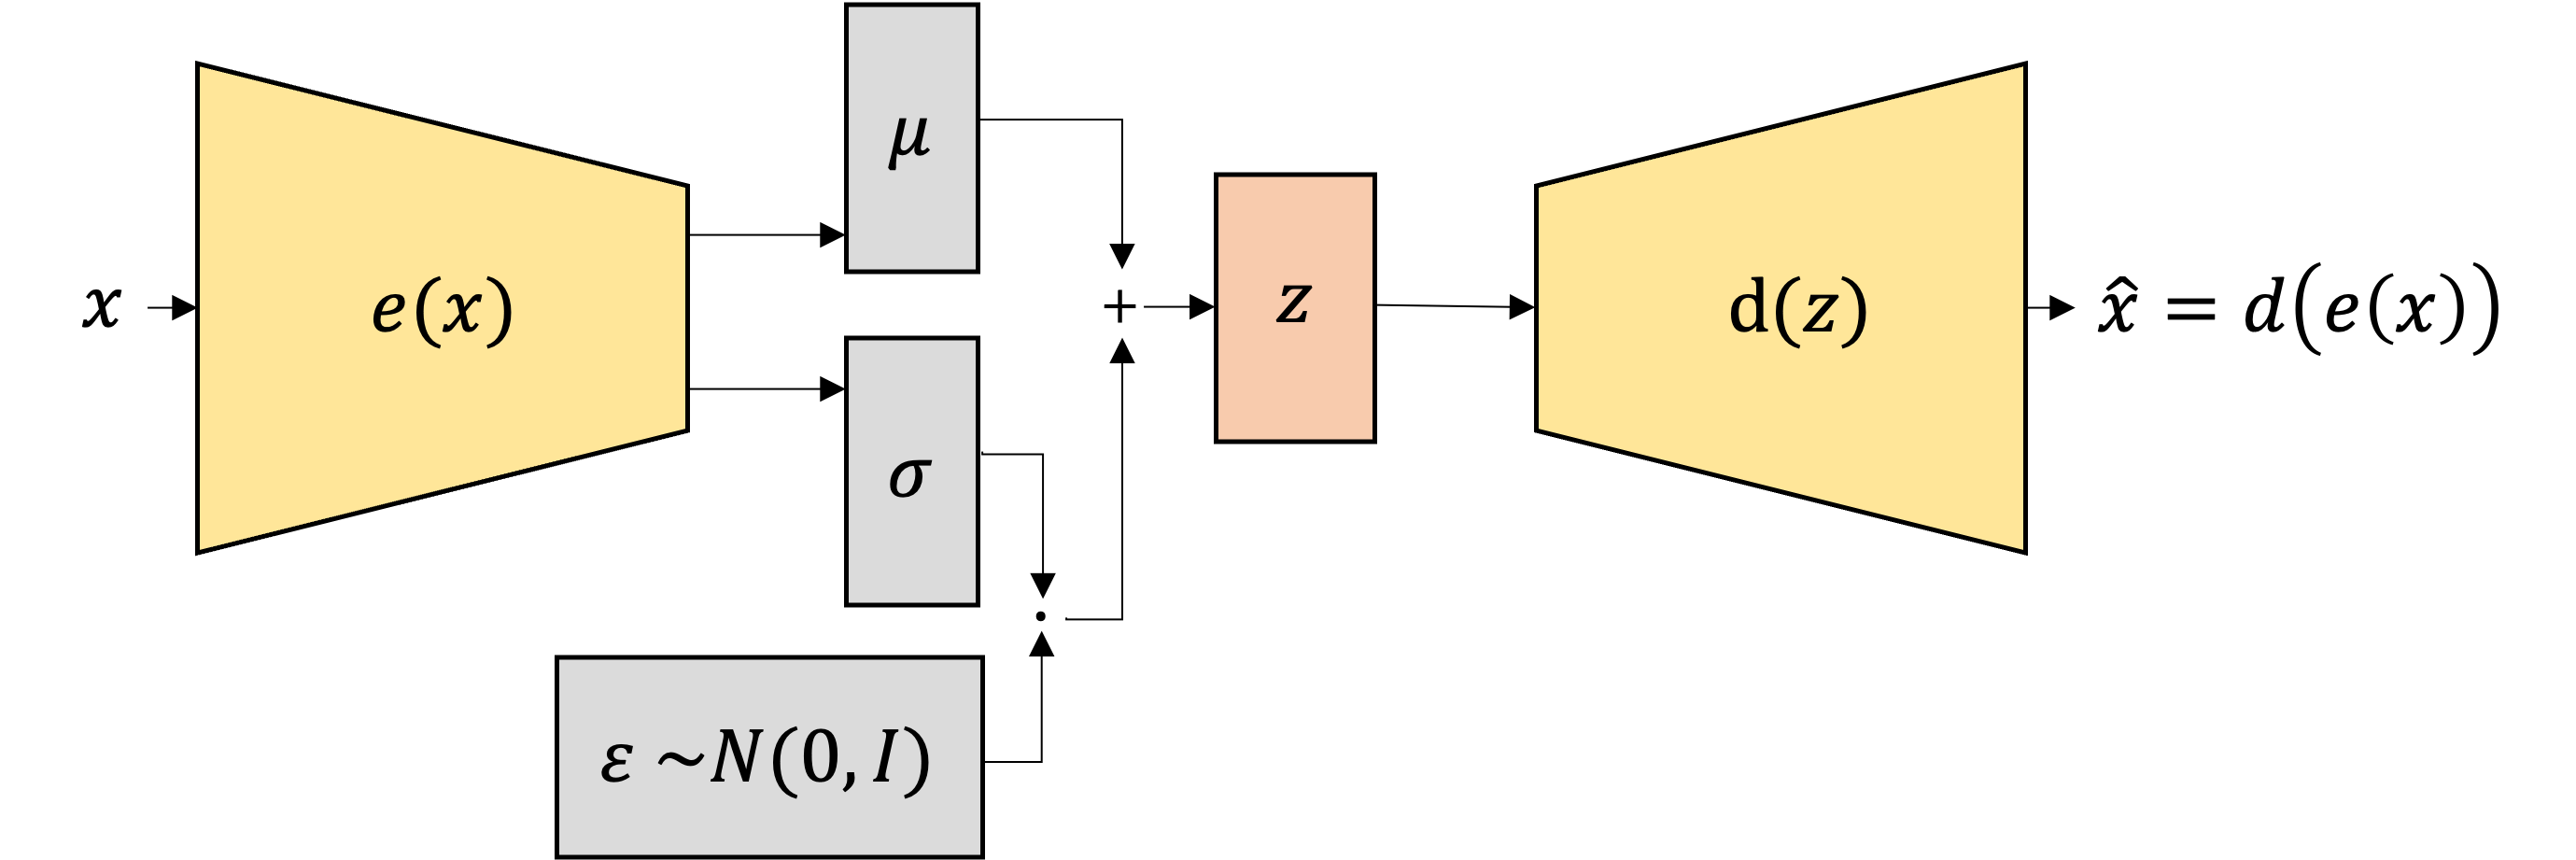

**Imports**

Before we begin, we import the needed libraries. 


You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.

In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
import torch.utils.data as data_utils
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile

%pip install wget   
import wget

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
arad = True


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=918ca279bf7f12544333570061bf1530c28981acffd9736b819d5c84e382989f
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Path to save the dataset.
PATH_TO_SAVE_MODEL = '/content/gdrive/MyDrive/Deep_Learning_Files/EX4' # TODO - UPDATE ME!
#/Volumes/GoogleDrive/My Drive/Deep_Learning_Files/EX4

Mounted at /content/gdrive


Define random seeds in order to reproduce your results.

In [3]:
# TO DO: Set random seeds - to your choice
torch.manual_seed(0)         # Insert any integer
torch.cuda.manual_seed(0)    # Insert any integer

## Question 1. Basic Principles (10 %)




### Part (a) -- 3%

What is the difference between deterministic autoencoder we saw in class and the variational autoencoder? 

In [ ]:
# Write your explanation here

The main difference between deterministic autoencoders and variational autoencoders is in the way the latent variable is produced.

In a deterministic autoencoder, the latent variable is a deterministic and compressed representation of the input, meaning that for each input there is a single mapping to the latent space (f(x) = z). 

In a variational autoencoder, the latent variable is a stochastic variable. The first and second moments of the latent variable are produced by a deterministic function, and these moments are used to create a probability density function which is used to sample from the latent space. These samples are the latent representation of the input, and they have a stochastic character, meaning that for the same input we can get different latent representations.

### Part (b) -- 3%
In which manner Variational Autoencoder is trained? Explain.


In [ ]:
# Write your explanation here

The loss function of Variational Autoencoder is composed with two components, 
the first is Reconstruction loss, and second is KL Divergence loss.

the Reconstruction loss is refering to the error between the decoded latent space to the input of the Encoder, usually measured by Croos-Entropy.

The KL Divergence loss is refering to the error between the error between the wanted probability function to the estimated one.

The final loss function, known as the ELBO (Evidence Lower Bound), is a combination of these two loss terms with a stabilization term. The ELBO is used as the objective function for training the variational autoencoder, and it is minimized using an optimization algorithm such as stochastic gradient descent.

One challenge in training a variational autoencoder is that the latent representation is a random variable, and therefore standard backpropagation techniques cannot be used to compute the gradients of the loss function with respect to the model parameters. To overcome this challenge, the reparameterization trick is often used. This involves representing the latent variable as an affine function of a noise variable and deterministic parameters.
$$ z = μ+Σ^{\frac{1}{2}}ϵ $$
This allows the gradients to be computed using standard techniques, and makes it possible to train the variational autoencoder using backpropagation.



### Part (c) -- 4%

In class we saw another generative model, known as generative adversarial network (GAN). What are the differences in terms of task objective between GANs and VAEs? Give an example for a task which a VAE is more suitable than GAN, and vice versa.

In [ ]:
# Write your explanation here

Variational Autoencoders(VAE) and Generative Adversarial Networks(GAN) are two types of generative models that are used to generate new samples that are similar to a training dataset.

The main difference between these two types of models is the objective function they are trained to optimize.

The VAEs are trained to maximize the likelihood of the training data,meaning that it will preform well on **reconstruction** tasks after learning the latent represntation.

the GANs are trained using a minimax objective, this means that in a GAN, the generator tries to produce samples that are similar to the training data, while the discriminator tries to distinguish real samples from generated ones. The generator and discriminator are trained alternately, with the goal of training the generator to produce samples that the discriminator cannot distinguish from real ones. Because GANs are trained to generate samples that are similar to real samples, they are often better suited for tasks such as **image generation** than VAEs.

## Question 2. Data (15 %)

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

Here, you will download the dataset to the Google Colab disk. It is highly recommended not to download the dataset to your own Google Drive account since it is time consuming.

In [4]:
data_path = "datasets" ## TO DO -- UPDATE ME!

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_path}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

### Part (a) -- 5%

Apply transformations:

The data is given as PIL (Python Imageing Library) images. Since we are working with PyTorch, we wish to apply transformations to the data in order to process it properly.

Here you should apply transformations to the data. There are many kinds of transformations which can be found here: https://pytorch.org/vision/stable/transforms.html. Note that transformations can be chained together using Compose method.

Think which transformations can be suitable for this task and apply it in the form of: 

trfm = transforms.Compose([transforms.transform1(),transforms.transform2(),...])

We recommend to consider:
- transforms.ToTensor()
- transforms.Resize()

In [5]:
trfm = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(128, 128))]) # You can add additional transformations which you think could be fit to the data.

training_data = datasets.CelebA(root=data_path, split='train', download=False, transform=trfm) #load the dataset (without download it directly) from our root directory on google drive disk. 
test_data = datasets.CelebA(root=data_path, split='test', download=False, transform=trfm)


### Part (b) -- 5%

In order to get in touch with the dataset, and to see what we are dealing with (which is always recommended), we wish to visualize some data samples from the CelebA dataset.

Write a function: show():

INPUT: Python list of length 32 where each element is an image, randomly selected from the training data.

OUTOUT: Showing a 8X4 grid of images.

In [48]:
def show(imgs):
    # your code goes here:
    fig, axes= plt.subplots(8,4, figsize=(20,20))
    row =0
    col = 0
    for i, img in enumerate(imgs):
      axes[row, col].imshow(img.permute(1,2,0).detach().numpy())
      axes[row, col].axis('off')
      
      col +=1
      if col>3:
        row +=1
        col = 0
    plt.tight_layout()
    plt.show()
    
    return None
# show(data_utils.Subset(training_data,torch.arange(1,33)))

### Part (c) -- 5%

Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

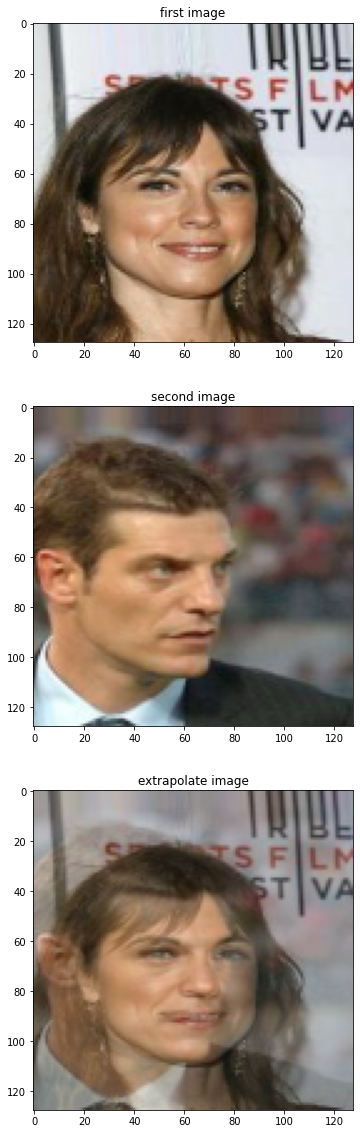

In [ ]:
# Your code goes here
imgs = random.choices([i for i in range(len(training_data))], k=2)
img1 = training_data[int(imgs[0])][0]
img2 = training_data[int(imgs[1])][0]
fig, axes= plt.subplots(3,1, figsize=(20,20))

axes[0].imshow(img1.permute(1,2,0))
axes[0].set_title('first image')
axes[1].imshow(img2.permute(1,2,0))
axes[1].set_title('second image')
axes[2].imshow(0.5*(img1+img2).permute(1,2,0))
axes[2].set_title('extrapolate image')
plt.show()


In [ ]:
# Your explanation goes here:

It is generally not reasonable to perform extrapolation in the image domain, because images do not have a consistent structure across different samples.

In our case, when extrapolating celebrity faces, it is unlikely that the resulting image will have a meaningful structure, because the location of features, such as the nose or the orientation of the head, are likely to vary significantly across different images. Therefore, averaging pixels across different images will not produce a meaningful result.

## Question 3. VAE Foundations (15 %)


Let us start by recalling the analytical derivation of the VAE.


The simplest version of VAE is comprised of an encoder-decoder architecture.
The *encoder* is a neural network which its input is a datapoint $x$, its output is a hidden representation $z$, and it has weights and biases $\theta$. We denote the encoder's mapping by $P_{\theta}(z|x)$. The *decoder* is another neural network which its input is the data sample $z$, its output is the reconstructed input $x$, and its parameters $\phi$. Hence, we denote the decoder's mapping by $P_{\phi}(x|z)$.

The goal is to determine a posterior distribution $P_{\theta}(z|x)$ of a latent variable $z$ given some data evidence $x$. However, determining this posterior distribution is typically computationally intractable, because according to Bayes:

$(1)$ $P(z|x) = \frac{P(x|z)P(z)}{P(x)}$

The term $P(x)$ is called the evidence, and we can calculate it by marginalization on the latent variable:

$P(x) = \int_{z}P(x|z)P(z)dz$

Unfortunately, this term is intractable because it requires computation of the integral over the entire latent space $z$. To bypass this intractability problem we approximate the posterior distribution with some other distribution $q(z|x_i)$. This approximation is made by the KL-divergence:

$(2)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = \int_{z}q(z|x_i)\cdot\log\big(\frac{q(z|x_i)}{P(z|x_i)}\big)dz = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(z|x_i)}{q(z|x_i)}\big)dz \geq 0$

Applying Bayes’ theorem to the above equation yields,

$(3)$ $D_{KL}\big(q(z|x_i)||P(z|x_i)\big) = -\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)P(x_i)}\big)dz \geq 0$

This can be broken down using laws of logarithms, yielding,

$(4)$ $-\int_{z}q(z|x_i)\cdot\big[\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)-\log(P(x_i))\big]dz \geq 0$

Distributing the integrand then yields,

$(5)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\int_{z}q(z|x_i)\log(P(x_i))dz \geq 0$

In the above, we note that $log(P(x))$ is a constant and can therefore be pulled out of the second integral above, yielding,

$(6)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i))\int_{z}q(z|x_i)dz \geq 0$

And since $q(z|x_i)$ is a probability distribution it integrates to 1 in the above equation, yielding,

$(7)$ $-\int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz+\log(P(x_i)) \geq 0$

Then carrying the integral over to the other side of the inequality, we get,

$(8)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(x_i|z)P(z)}{q(z|x_i)}\big)dz$

<!-- Applying rules of logarithms, we get,

$(9)$ $\log(P(x)) \geq \int_{z}q(z|x)\cdot\big[\log\big(P(x|z)\big)+\log\big(P(z)\big)-\log\big(q(z|x)\big)\big]dz$

Recognizing the right hand side of the above inequality as Expectation, we write,

$(10)$ $\log(P(x)) \geq E_{~q(z|x)}\big[\log\big(P(x,z)\big)-\log\big(q(z|x)\big)\big]dz$ -->

From Equation $(8)$ it follows that:

$(9)$ $\log(P(x_i)) \geq \int_{z}q(z|x_i)\cdot\log\big(\frac{P(z)}{q(z|x_i)}\big)dz + \int_{z}q(z|x_i)\cdot\log\big(P(x_i|z)\big)dz$

Which is equivalent to:

$(10)$ $\log(P(x_i)) \geq -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$



The right hand side of the above equation is the Evidence Lower BOund (ELBO). Its bounds $\log(P(x))$ which is the term we seek to maximize. Therefore, maximizing the ELBO maximizes the log probability of our data. 


### Part (a) -- 5%
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



In [ ]:
# Write your explanation here

In the ELBO (Evidence Lower Bound) loss function, the first is the **KL divergence**, measures the distance between the approximate posterior distribution over the latent variable and the prior distribution. A smaller KL divergence indicates that the approximate posterior is a good approximation of the true posterior, and therefore the model is able to effectively capture the structure of the data. In the ELBO, the KL divergence term appears with a negative sign, so when the ELBO is maximized, the KL divergence is minimized.

The second term is the **log-likelihood**, measures the probability of the data given the latent variable, and a higher log-likelihood indicates a better fit of the model to the data. When the ELBO is maximized, the log-likelihood is maximized.

This means that the ELBO loss function is minimizing the difference between the approximate posterior and the prior distribution, while simultaneously maximizing the fit of the model to the data.

### Part (b) -- 10%

 As we saw in class, in traditional variational autoencoder we assume:

$P(z)$ ~ $N(\mu_p,\sigma_{p}^2) = \frac{1}{\sqrt{2\pi\sigma_{p}^2}}\exp\big(-\frac{(z-\mu_p)^2}{2\sigma_{p}^2}\big)$

and

$q(z|x)$ ~ $N(\mu_q,\sigma_{q}^2) = \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)$

Assume $\mu_p = 0$ and $\sigma_{p}^2 = 1$. Show that:

$ -D_{KL}\big(q(z|x_i)||P(z)\big) = \frac{1}{2}\big[1+\log(\sigma_{q}^2)-\sigma_{q}^2-\mu_q^2\big]$ 

 

**WRITE YOUR SOLUTIUON HERE**. (You can also upload your solution as an image.)



$$ D_{KL}(q(z|x_i)||P(z)) = \int_{z∈Ω_z} q(z|x_i) log(\frac{q(z|x_i)}{P(z)})dz =$$
$$
=\int_{z∈Ω_z} \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big) * log(\frac{\frac{1}{\sqrt{2\pi\sigma_{q}^2}}\exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)}{\frac{1}{\sqrt{2\pi\sigma_{p}^2}}\exp\big(-\frac{(z-\mu_p)^2}{2\sigma_{p}^2}\big)})dz = $$
$$ = \frac{1}{\sqrt{2\pi\sigma_{q}^2}}\int_{z∈Ω_z} \exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big) *[ log(\frac{\sigma_{p}}{\sigma_{q}})+\frac{(z-\mu_p)^2}{2\sigma_{p}^2} - \frac{(z-\mu_q)^2}{2\sigma_{q}^2}]dz  $$

let's calculate separtly each integral,

$$\frac{1}{\sqrt{2\pi\sigma_{q}^2}}\int_{z∈Ω_z} \exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)*log(\frac{\sigma_{p}}{\sigma_{q}})dz = log(\frac{\sigma_{p}}{\sigma_{q}}) = -log(\sigma_q)  $$

$$-\frac{1}{\sqrt{2\pi\sigma_{q}^2}}\int_{z∈Ω_z} \exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)\frac{(z-\mu_q)^2}{2\sigma_{q}^2}dz = -\frac{1}{2} $$

$$\frac{1}{\sqrt{2\pi\sigma_{q}^2}}\int_{z∈Ω_z} \exp\big(-\frac{(z-\mu_q)^2}{2\sigma_{q}^2}\big)\frac{(z-\mu_p)^2}{2\sigma_{p}^2}dz = \frac{\sigma_q^2 + \mu_q^2 - 2\mu_p\mu_q+\mu_p^2}{2\sigma_p^2} = \frac{\sigma_q^2 + \mu_q^2}{2}   $$

so in total we get, 

$$  -D_{KL}(q(z|x_i)||P(z)) = log(\sigma_q)+ \frac{1}{2}-\frac{\sigma_q^2 + \mu_q^2}{2} = \frac{1}{2}[1+log(\sigma_q^2) - \sigma_q^2 - \mu_q^2] $$




**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## Question 4. VAE Implementation (25 %)

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




***Transposed Convolution with Stride = 1***

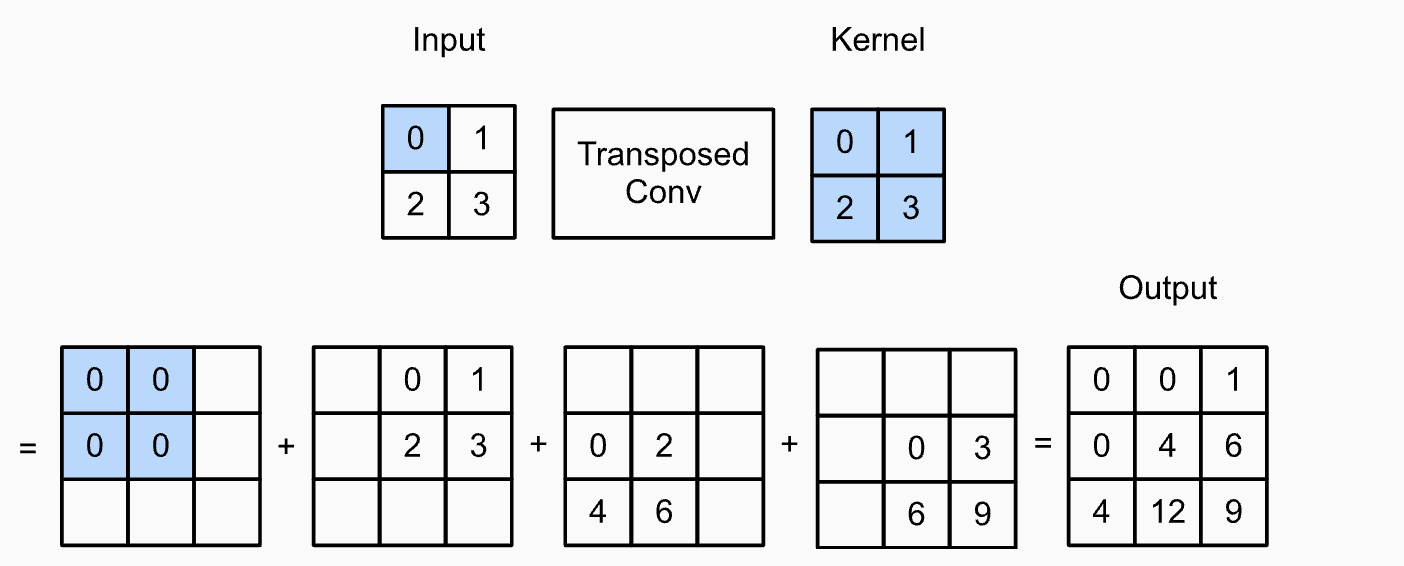

***Transposed Convolution with Stride = 2***
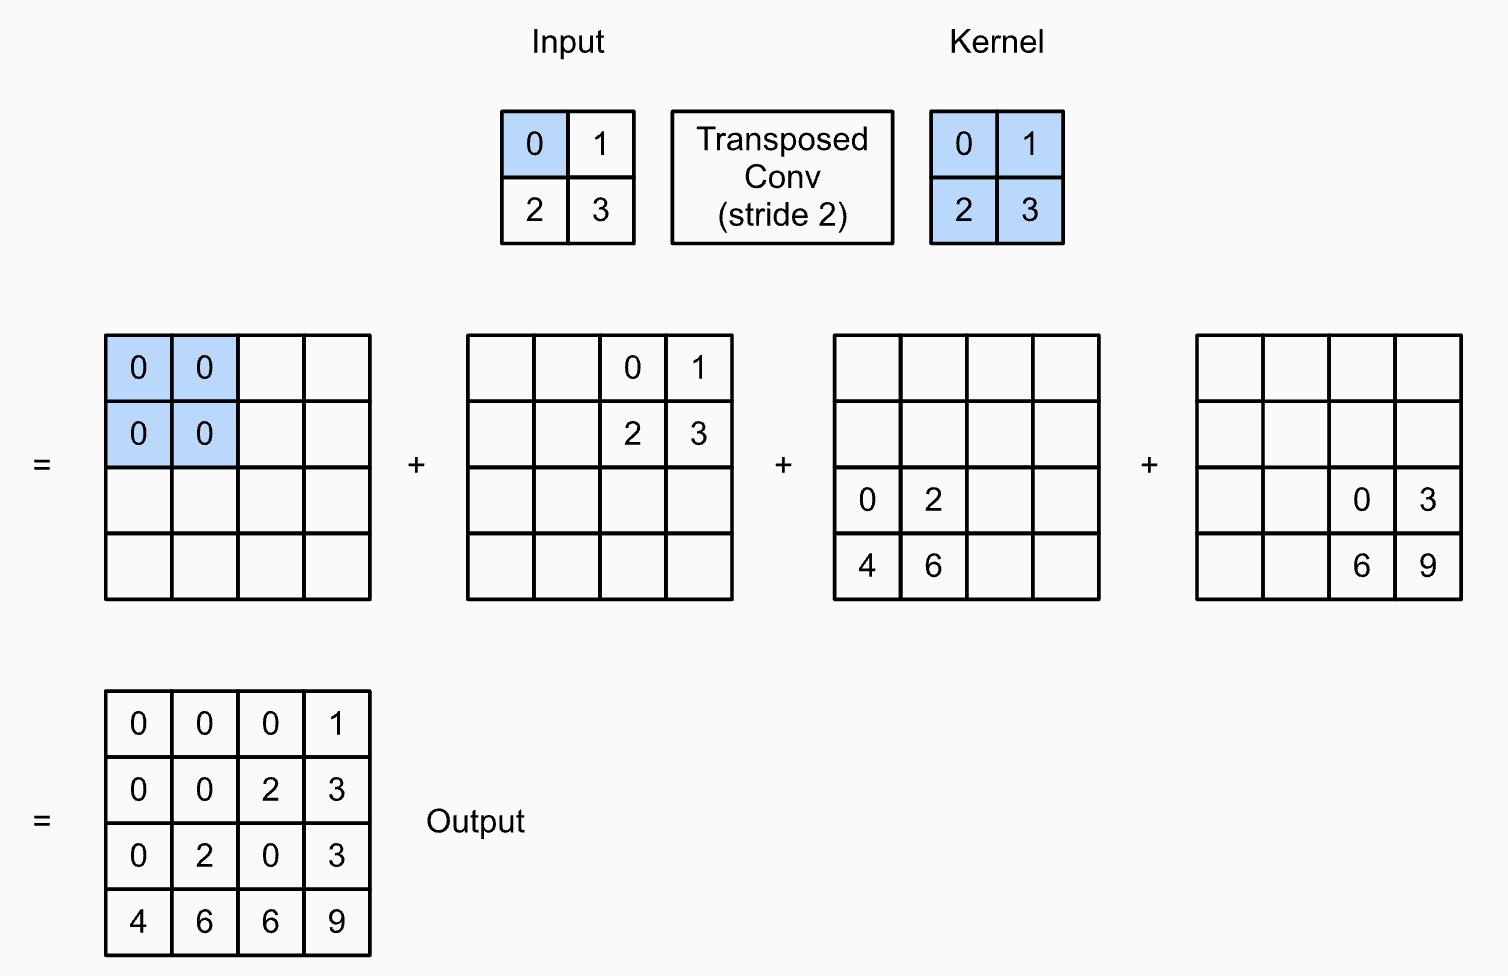

The architecture of your VAE network should be in the following form:


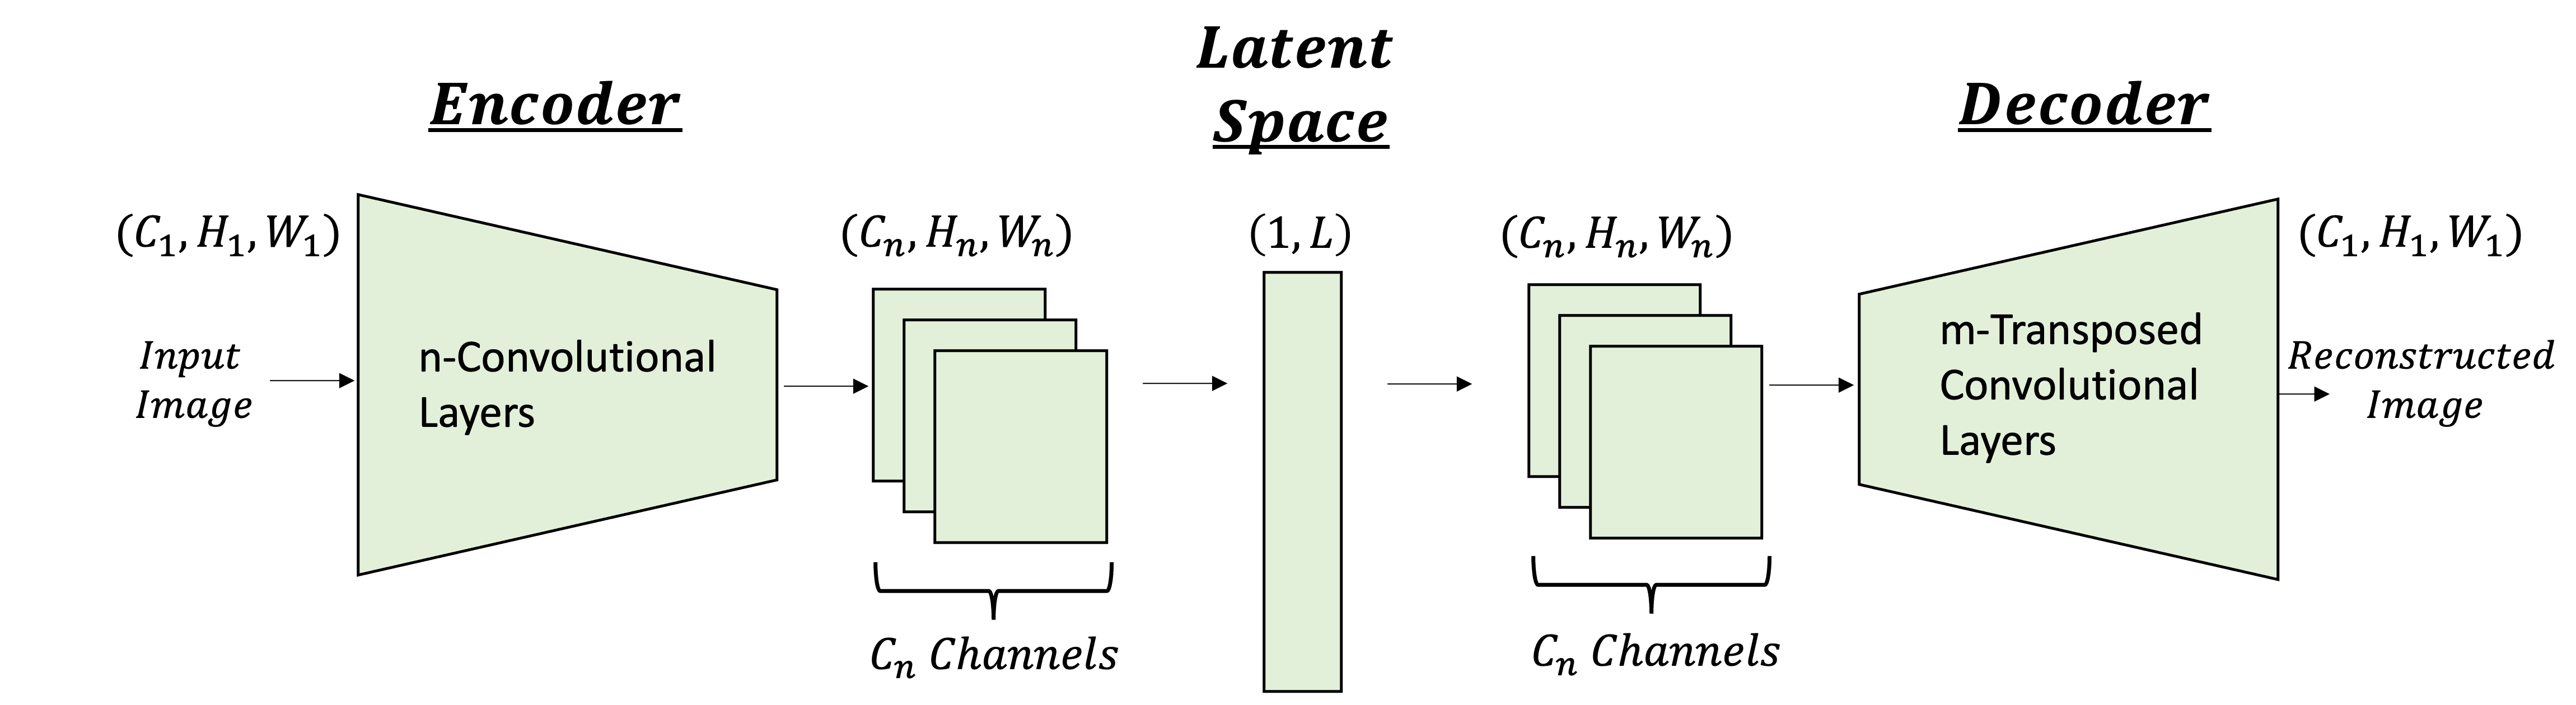

### Part (a) -- 7%

 **Encoder**

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(H_4\cdot W_4\cdot C_4 , latent)$, where $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [74]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:

        self.num_hiddens = num_hiddens
        self.latent = latent
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.ReLU())
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d( 2 * num_hiddens),
                                    nn.ReLU())

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d( 4 * num_hiddens),
                                    nn.ReLU())
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d( 8 * num_hiddens),
                                    nn.ReLU())
        
        self.fc_mu = nn.Linear(num_hiddens*8*8*8,latent)     # Insert the input size
        self.fc_logvar = nn.Linear(num_hiddens*8*8*8,latent) # Insert the input size

    def forward(self, inputs):

        # YOUR CODE GOES HERE:
        x= self.block1(inputs)

        x= self.block2(x)

        x= self.block3(x)
        
        x= self.block4(x)
        
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)


        return mu, logvar 

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Part (b) -- 7%
 **Decoder**

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [78]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,latent):
        super(Decoder, self).__init__()
        # YOUR CODE GOES HERE:
        self.num_hiddens = num_hiddens
        self.in_channels = in_channels
        self.fc_dec = nn.Linear(latent,in_channels*8*8) 

        self.block1 = nn.Sequential(nn.ConvTranspose2d(in_channels, num_hiddens // 2, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens // 2), 
                                    nn.LeakyReLU())
        
        self.block2 = nn.Sequential(nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens // 4), 
                                    nn.LeakyReLU())

        self.block3 = nn.Sequential(nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens // 8), 
                                    nn.LeakyReLU())
        
        self.block4 = nn.Sequential(nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=(4,4), stride=(2,2), padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens // 8), 
                                    nn.LeakyReLU())

        self.block5 = nn.Sequential(nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                                    nn.Sigmoid()) # -> we want that 0<= output <= 1


    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        
        x = self.fc_dec(inputs)
        x = x.view(x.size(0), self.in_channels ,8,8) 

        x = self.block1(x)

        x = self.block2(x)

        x = self.block3(x)

        x = self.block4(x)

        x_rec = self.block5(x)

        return x_rec

### Part (c) -- 4% 
**VAE Model**

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [80]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent):
        super(VAE, self).__init__()
        self.encode = Encoder(in_channels=enc_in_chnl, num_hiddens=enc_num_hidden,latent = latent)
        self.decode = Decoder(in_channels=dec_in_chnl, num_hiddens=dec_num_hidden,latent = latent)
        self.weight_init(mean=0, std=0.02)
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)     
      return eps.mul(std).add_(mu)

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_rec = self.decode(z)


        return x_rec , mu, logvar, z

### Part (d) -- 7% 

**Loss Function**

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

In [ ]:
# Write your explanation here


The parameter beta is controls the relative weight of BCE and the KLD in the total loss function.
The way that the parametes affect the total loss is:    beta * KLD + BCE . 

As we can see a large value of beta (beta >> 1) will put more weight on the KLD loss, that will encourege the latent space to be more  disentangled and interpretable.

A small value of beta (beta << 1) will put more weight on the BCE loss
it will encourege the reconstarctur to be more efficient.

Of course those two qualities should be balanced as much as possible to get the best results for our purpose.

Here you should write specifically the code for the loss function.


In [10]:
import tensorflow as tf
beta = 0.1
# def vae_loss(x_recon, x, mu, logvar):

#     # setting x and x+recon to be in the interval [0,1]
#     #x = torch.sigmoid(x)
#     #x_recon = torch.sigmoid(x_recon)


#     #KLD
#     KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
#     #BCE
#     BCE = nn.functional.binary_cross_entropy(x_recon, x, reduction='mean')

    
#     return BCE, KLD*beta
# ######################################################

def gaussian_likelihood(x_hat, logscale, x):
    scale = torch.exp(logscale)
    mean = x_hat
    dist = torch.distributions.Normal(mean, scale)
    # measure prob of seeing image under p(x|z)
    log_pxz = dist.log_prob(x)
    return log_pxz.sum(dim=(1, 2, 3))

def vae_loss1(x_recon, x, mu, logvar,log_scale):
    recon_loss =gaussian_likelihood(x_recon,log_scale,x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),dim=-1).mean(dim=0)
    return recon_loss.mean(dim=0), KLD*beta

In [ ]:
# enc_in_chnl = 3
# enc_num_hidden = 30
# dec_in_chnl = 8
# dec_num_hidden = 30
# latent = 12
# V = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent)

# x = torch.zeros((1,3,128,128))
# x_rec, mu, logvar, _ = V(x)


# BCE, KLD = vae_loss1(x_rec, x, mu, logvar, V.log_scale)
# print(BCE)
# print(KLD)

 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

In [81]:
learning_rate = 0.001
batch_size = 128
num_epochs = 10
dataset_size = 30000 # How many data samples to use for training, 30,000 should be enough.

#VAE Class inputs: 
enc_in_chnl = 3
enc_num_hidden = 32
dec_in_chnl = 256
dec_num_hidden = 256

In [82]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True) 

## Question 5. VAE Training (15 %)



### Part (a) -- 4% 
Complete the training function below

In [84]:
import torch.optim as optim
def train(model,
          train_data = train_loader,
          testing_data = test_loader,
          num_epochs = num_epochs ,
          batch_size = batch_size,
          dataset_size = dataset_size,
          learning_rate = learning_rate,
          weight_decay = 0,
          max_iters = None,
          checkpoint_path = "/content/gdrive/MyDrive/Deep_Learning_Files/EX4/VAE_model_E_{} -{}.pk"):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''
    
    # Your code goes Here:
    optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
                          weight_decay=weight_decay)
    iters, losses = [], []
    val_iters, val_losses = [], []
    test = iter(testing_data)
    #model.train()   
    n = 0
    val_n = 0
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(train_data):
            imgs, _ = batch
            if torch.cuda.is_available():
                imgs = imgs.cuda()
            else:
                imgs = imgs.to(device)
            
            optimizer.zero_grad()

            # data -> model
            x_rec, mu, logvar ,z= model(imgs)

            # get loss
            #BCE, KLD = vae_loss(x_rec, imgs, mu, logvar)
            #loss = KLD + BCE

            BCE, KLD = vae_loss1(x_rec, imgs, mu, logvar, model.log_scale)
            loss = KLD - BCE

            loss.backward()
            optimizer.step()
            loss = loss.cpu().detach().numpy()
            losses.append(loss)
            iters.append(n)
            
            
            if n % 50 == 0:
              val_n +=1
              # Validation set
              with torch.no_grad():
                  model.eval()     
                  try:
                      imgs, _ = next(test)
                  except StopIteration:
                      test = iter(testing_data)
                      imgs, _ = next(test) 
                  if torch.cuda.is_available():
                      imgs = imgs.cuda()
                  else:
                      imgs = imgs.to(device)
                  x_rec, mu, logvar, _ = model(imgs)
                  BCE, KLD = vae_loss1(x_rec, imgs, mu, logvar, model.log_scale)
                  val_loss = KLD - BCE
                  val_losses.append(float(val_loss))
                  val_iters.append(val_n)

                  print("Epoh. {}, Iter. {}, Train Loss : {:.6f}, Valid Loss : {:.6f}".format(epoch, n, loss, val_loss))
              if (checkpoint_path is not None) and n > 0:
                  torch.save(model.state_dict(), checkpoint_path.format(epoch, n))

                    
            # Since the dataset is large, train on 'dataset_size' samples.
            if dataset_size//batch_size == batch_idx: 
                break
            if max_iters is not None:
                if n >= max_iters:
                    break
            
            n += 1
    return iters, losses, val_iters, val_losses

def plot_learning_curve(iters, losses, val_iters, val_losses):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration Training")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.title("Learning Curve: Loss per Iteration Validation")
    plt.plot(val_iters, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Part (b) -- 4%  

We first train with dimension of latent space $L=3$

We recommend to use *weight_init()* function, which helps stabilize the training process. 

In [86]:
latent1 = 3
# torch.cuda.empty_cache()
if torch.cuda.is_available():
    model1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1).cuda()
#     # model_1.weight_init(mean=0, std=0.02)
else:
    model1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
#     # model_1.weight_init(mean=0, std=0.02)
if arad:
  save_path_l3 = "/content/gdrive/MyDrive/Data/assigment4/VAEmodel_l3/param_l3_E{}_iter{}.pk"
else:
  save_path_l3 = "/content/gdrive/MyDrive/Deep_Learning_Files/EX4/VAE_model_l3_E_{} -{}.pk"
plot_model_1 = train(model1,checkpoint_path=save_path_l3, max_iters=1150)

Epoh. 0, Iter. 0, Train Loss : 47909.691406, Valid Loss : 47345.550781
Epoh. 0, Iter. 50, Train Loss : 44420.757812, Valid Loss : 44304.042969
Epoh. 0, Iter. 100, Train Loss : 41728.410156, Valid Loss : 41639.531250
Epoh. 0, Iter. 150, Train Loss : 39177.000000, Valid Loss : 39152.253906
Epoh. 0, Iter. 200, Train Loss : 36705.566406, Valid Loss : 36703.867188
Epoh. 1, Iter. 250, Train Loss : 34467.765625, Valid Loss : 34340.996094
Epoh. 1, Iter. 300, Train Loss : 31941.751953, Valid Loss : 32051.957031
Epoh. 1, Iter. 350, Train Loss : 29827.476562, Valid Loss : 29888.767578
Epoh. 1, Iter. 400, Train Loss : 27575.902344, Valid Loss : 27588.154297
Epoh. 1, Iter. 450, Train Loss : 25568.554688, Valid Loss : 25413.869141
Epoh. 2, Iter. 500, Train Loss : 23039.488281, Valid Loss : 23188.613281
Epoh. 2, Iter. 550, Train Loss : 21026.324219, Valid Loss : 21134.003906
Epoh. 2, Iter. 600, Train Loss : 19173.675781, Valid Loss : 19131.835938
Epoh. 2, Iter. 650, Train Loss : 17072.587891, Valid L

Train your model, plot the train and the validation loss graphs. Explain what is seen.

In [87]:
# plot_learning_curve(plot_model_1[0], plot_model_1[1][0], plot_model_1[2], plot_model_1[3])
plot_learning_curve(*plot_model_1)

Both the training and validation loss are consistently decreasing, indicating that the model is training well and is not overfitting. It is also worth noting that the losses are not converging, suggesting that the model may continue to improve with further training. This indicates that there is still room for improvement in the model's performance.

In [ ]:
# latent1 = 3
# model_1 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent1)
# path = "/content/gdrive/My Drive/Deep_Learning_Files/EX4/VAE_model_l3_E_29 -7000.pk"
# model_1.load_state_dict(torch.load(path))

RuntimeError: ignored

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Explain.

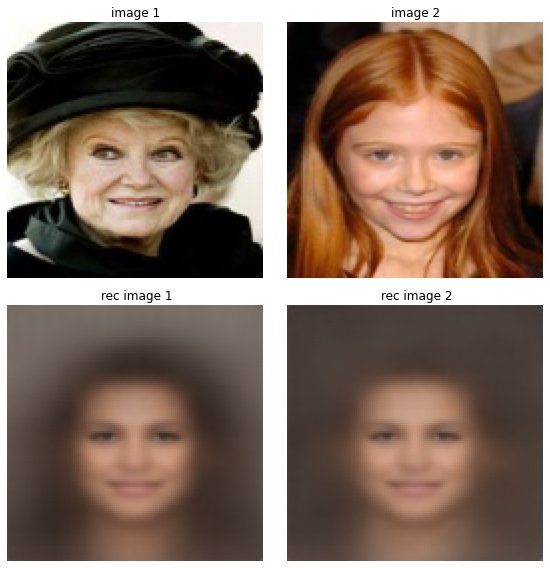

In [89]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
img1= test_data[0][0]
img1_rec = model1(img1.reshape(1,3,128,128).cuda())[0]

img2= test_data[2][0]
img2_rec = model1(img2.reshape(1,3,128,128).cuda())[0]


ax[0,0].imshow(img1.permute(1,2,0))
ax[0,0].set_title('image 1')
ax[0,0].axis("off")
ax[1,0].imshow(img1_rec[0].permute(1,2,0).cpu().detach().numpy())
ax[1,0].set_title(' rec image 1')
ax[1,0].axis("off")

ax[0,1].imshow(img2.permute(1,2,0))
ax[0,1].set_title('image 2')
ax[0,1].axis("off")
ax[1,1].imshow(img2_rec[0].permute(1,2,0).cpu().detach().numpy())
ax[1,1].set_title(' rec image 2')
ax[1,1].axis("off")

plt.tight_layout()
plt.show()


From the reconstructed images, it is clear that the model is able to capture the main features of a human face, such as the eyes, nose, and mouth. However, the model appears to struggle with finer details, as the reconstructed images are similar for different inputs. This may be due to the low latent dimension, which does not provide enough capacity for the model to distinguish between similar images with potentially similar latent representations. As a result, the model is able to easily identify that an input is a face, but struggles with more specific details.

### Part (c) -- 7%  

Next, we train with larger $L > 3$

Based on the results for $L = 3$, choose a larger $L$ to improve your results.
Train new model with your choice for $L$.

In [90]:
latent2 = 50  # TO DO: Choose latent space dimension.

if torch.cuda.is_available():
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2).cuda()
    # model_2.weight_init(mean=0, std=0.02)
else:
    model_2 = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2)
    # model_2.weight_init(mean=0, std=0.02)
    
# optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
if arad:
  save_path_l50 = "/content/gdrive/MyDrive/Data/assigment4/VAEmodel_l50/param_l50_E{}_iter{}.pk"
else:
  save_path_l50 = "/content/gdrive/MyDrive/Deep_Learning_Files/EX4/VAE_model50_E_{} -{}.pk"
plot_model_2 = train(model_2,checkpoint_path=save_path_l50, max_iters=950)

Epoh. 0, Iter. 0, Train Loss : 47670.816406, Valid Loss : 47393.660156
Epoh. 0, Iter. 50, Train Loss : 44248.945312, Valid Loss : 43943.488281
Epoh. 0, Iter. 100, Train Loss : 41225.695312, Valid Loss : 41141.687500
Epoh. 0, Iter. 150, Train Loss : 38519.210938, Valid Loss : 38478.925781
Epoh. 0, Iter. 200, Train Loss : 35969.539062, Valid Loss : 35947.214844
Epoh. 1, Iter. 250, Train Loss : 33445.296875, Valid Loss : 33415.210938
Epoh. 1, Iter. 300, Train Loss : 30988.572266, Valid Loss : 30915.181641
Epoh. 1, Iter. 350, Train Loss : 28504.242188, Valid Loss : 28531.943359
Epoh. 1, Iter. 400, Train Loss : 26185.345703, Valid Loss : 26060.794922
Epoh. 1, Iter. 450, Train Loss : 23691.123047, Valid Loss : 23653.160156
Epoh. 2, Iter. 500, Train Loss : 21252.523438, Valid Loss : 21218.990234
Epoh. 2, Iter. 550, Train Loss : 18776.916016, Valid Loss : 18806.173828
Epoh. 2, Iter. 600, Train Loss : 16382.009766, Valid Loss : 16358.867188
Epoh. 2, Iter. 650, Train Loss : 13977.454102, Valid L

Plot the train and the validation loss graphs. Explain what is seen.

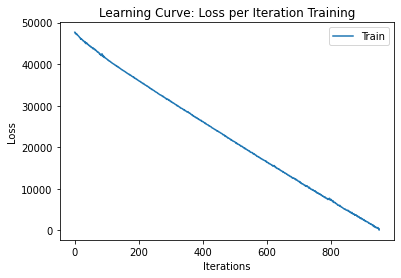

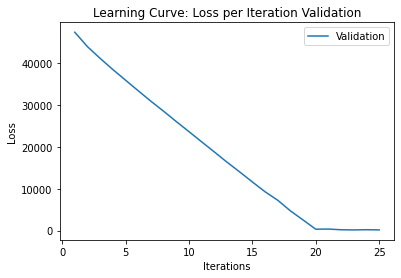

In [91]:
# Your Code Goes Here
plot_learning_curve(*plot_model_2)

As with the first model, the training and validation loss for the second model are consistently decreasing, indicating that the model is training well and may continue to improve with further training

Visualize, from the test dataset, an original image against a reconstructed image. Has the model reconstructed the image successfully? Are the images identical? Explain.

In [20]:
# model_2_loaded = VAE(enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent2)
# if arad:
  # path = "/content/gdrive/MyDrive/Data/assigment4/VAEmodel_l50/param_l50_E4_iter950.pk"
# else:
  # path = "/content/gdrive/MyDrive/Deep_Learning_Files/EX4/VAE_model70_E_3 -930.pk"
# model_2_loaded.load_state_dict(torch.load(path))

<All keys matched successfully>

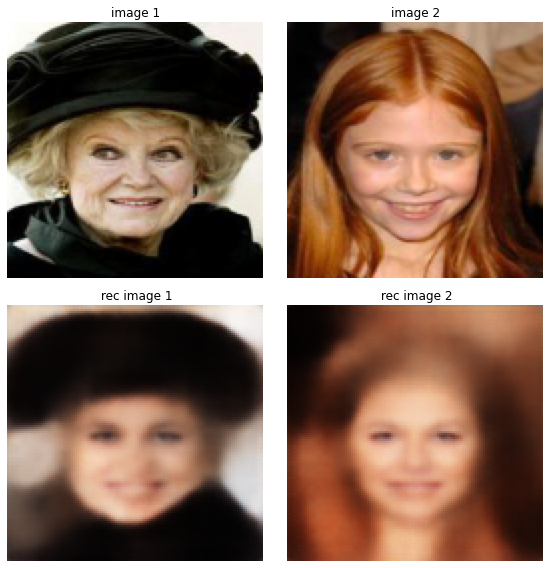

In [92]:
# Your Code Goes Here
fig, ax = plt.subplots(2,2,figsize=(8,8))
img1= test_data[0][0]
img1_rec = model_2(img1.reshape(1,3,128,128).cuda())[0]

img2= test_data[2][0]
img2_rec = model_2(img2.reshape(1,3,128,128).cuda())[0]


ax[0,0].imshow(img1.permute(1,2,0))
ax[0,0].set_title('image 1')
ax[0,0].axis("off")
ax[1,0].imshow(img1_rec[0].permute(1,2,0).cpu().detach().numpy())
ax[1,0].set_title(' rec image 1')
ax[1,0].axis("off")

ax[0,1].imshow(img2.permute(1,2,0))
ax[0,1].set_title('image 2')
ax[0,1].axis("off")
ax[1,1].imshow(img2_rec[0].permute(1,2,0).cpu().detach().numpy())
ax[1,1].set_title(' rec image 2')
ax[1,1].axis("off")

plt.tight_layout()
plt.show()


In comparison to the previous model, the reconstructed images from the current model contain much more details. For each test image used as input, the output is different, featuring various details such as the background, hair style, accessories, head orientation, and so on. This suggests that the current model is able to capture more fine details in the images compared to the previous model.

 What will happened if we choose extremely high dimension for the latent space?

In [ ]:
# Write your explanation here

From the two models we saw that the higher the latent space is, the better recounstruction is.
so its logical to assume that the higher the latent space is the better the reconstruction will be.

for instance, if we will take the latent space dimention to be high almost as the image size, 
the NN mught create a latent space that is almost equvalent to the image space - in that case it is clear why the reconstructorction will perform better.(might cause slower training)

But we should be aware that it might cause overfitting, and also it might detiriorate the ability of the NN to generate new face images, because that in the extreme case we described above there is no meaning for representing the image in the latent space, of course that this is extreme case, but we can learn from it the basic influences of larger latent space.


 
Did you output blurry reconstructed images? If the answer is yes, explain what could be the reason. If you got sharp edges and fine details, explain what you did in order to achieve that. 

Note: If you got blurry reconstructed images, just explain why. You dont need to change your code or retrain your model for better results (as long as your results can be interpreted as a human face).
 

In [ ]:
# Write your explanation here

There are several potential causes for blurry reconstructed images.

One possible reason is a low latent space dimension, which may result in a lossy reconstruction at the output. In this case, the latent space dimension of L=50 may be too small to accurately capture the details of the 128x128x3 input images, leading to a noisy reconstruction.

Another possible cause is the data used for training. If the training data set is small or not diverse enough, the model may not be able to learn a generalized distribution of celebrity faces and may struggle to reconstruct images that are significantly different from the training data. For example, if the training data does not include people with hats or sunglasses, the model may have difficulty reconstructing images of people wearing these accessories. To improve the quality of the reconstructions, it may be helpful to use a larger and more diverse training data set.

## Question 6: Generate New Faces (10 %)

Now, for the fun part!

We are going to generate new celebrity faces with our VAE models. A function for new faces generation is given to you. Modify it (if needed) to fit your code. 



In [41]:
# creates random noise sample in the correct shape.
def generate_faces(model, grid_size, latent):
    model.eval()
    dummy = torch.empty([batch_size,latent])
    z = torch.randn_like(dummy).to(device)

    #insert the random noise to the decoder to create new samples.
    sample = model.decode(z)
    new_face_list = []

    j=0
    while j < grid_size: 
        new_face_list.append(sample[j].cpu())
        j+=1

    # grid = make_grid(new_face_list)
    # print(type(grid))
    return new_face_list

**Model 1 ($L = 3$) results:**

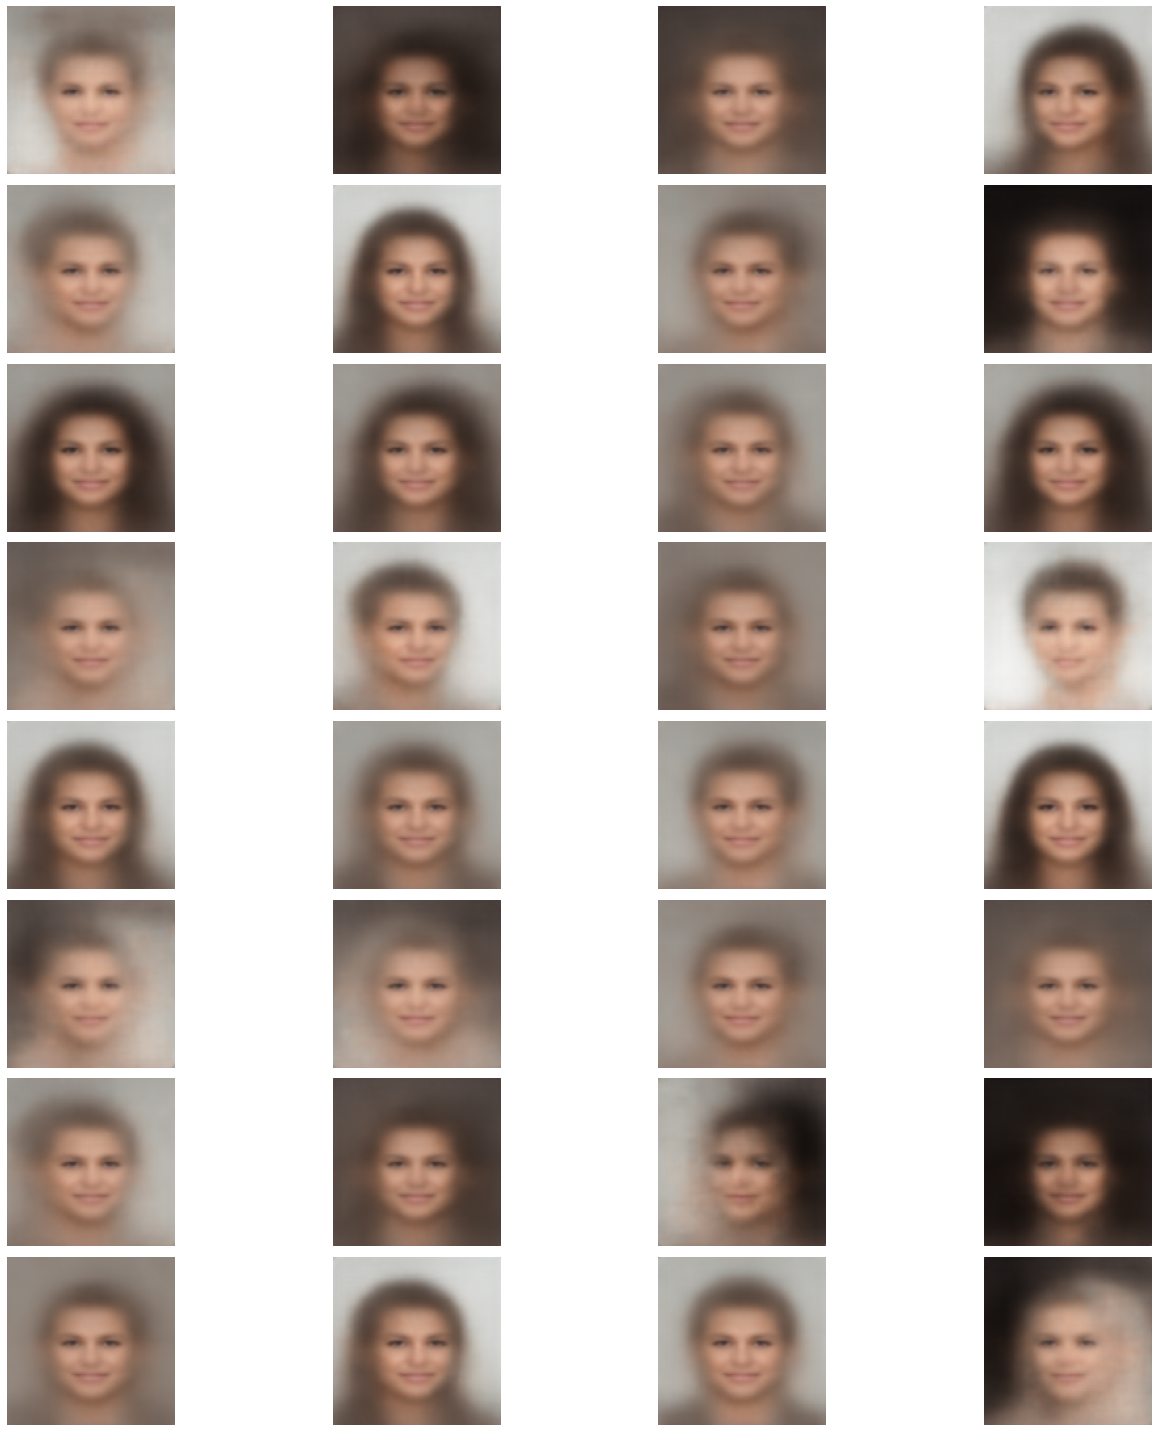

In [94]:
new_faces1 = generate_faces(model1,grid_size=32,latent=latent1)
show(new_faces1)

**Model 2 results:**

In [95]:
new_faces2 = generate_faces(model_2,grid_size=32,latent=latent2)
show(new_faces2)

*Q1:* Generate new faces with VAE model with latent space dimension = 3. Did you get diverse results? What are the most prominent features that the latent space capture? 

*Q2:* Generate new faces with VAE model with your decision for latent space dimension. What are the most prominent features that the latent space capture? 

*Q3:* What are the differences? Your results are similar to the dataset images? Do you get realistic images for your chosen latent space dimension? If not, change your decision or your network to acheive more realistic results.

In [ ]:
#YOUR ANSWERS GOES HERE

# Q1 Answer: 


# Q2 Answer: 


# Q3 Answer: 


**Q1 Answer:** 

With latent space = 3 , the diversity of faces is small, we can see that the most prominent features that our latent space captures are
the structure of the face, chicks, eyes, and nose. In general all those features are features that are more or less similar in every face. 

**Q2 Answer:**

with latent space = 50 , the the diversity of faces is bigger,  we can see that the most prominent features that our latent space captures are
the features that sre different from face to face, such as hair, position in the image and face expression.

**Q3 Answer:**

There are some differences in the generated faces produced by the two models. The first model generates images that are less noisy, but they do not look as realistic as the faces generated by the second model. The second model generates images that are more noisy, but they also contain more features that make them appear more realistic. While there are some unrealistic results from both models, the second model seems to produce a higher proportion of more realistic images.

It is possible that further training or a larger latent space may improve the results, but it is also likely that the noise in the generated images will always be present to some degree because adding more features to the decoder can make it difficult to produce high-quality output.

## Question 7: Extrapolation (10 %)

Recall that we extrapolate in the images domain in Question 2, part (c).
Here, extrapolate in the latent space domain to generate new images.

Define $\beta = [0, 0.1, 0.2, ... , 0.9, 1]$ and randomly sample from $Z \sim \mathcal{N(0,1)}$ 2 different samples and generate 2 new face images: $X_1, X_2$.

Extrapolate in the latent domain as follows: $\beta_i\cdot Z_1 + (1-\beta_i)\cdot Z_2$ for each $\beta_i \in \beta$.

Plot the extrapolation of the images for each $\beta$ and discuss your results. 
Repeat the process for 3 different samples.



In [96]:
def extrapolate_latent_domain(model, latent):
  
  beta_value = [i/10 for i in range(11)]

  model.eval()
  batch_size = 3

  for i in range(batch_size):
    
      dummy1 = torch.empty([1,latent])
      z1 = torch.randn_like(dummy1).to(device)
      img1 =  model.decode(z1)

      dummy2 = torch.empty([1,latent])
      z2 = torch.randn_like(dummy2).to(device)
      img2 =  model.decode(z2)
      fig, axes = plt.subplots(1,2, figsize=(8,8))
      axes[0].imshow(img1[0].permute(1,2,0).cpu().detach().numpy())
      axes[0].set_title("image 1")
      axes[0].axis("off")
      axes[1].imshow(img2[0].permute(1,2,0).cpu().detach().numpy())
      axes[1].set_title("image 2")
      axes[1].axis("off")

      fig1, axes1 = plt.subplots(1,11, figsize=(20,20))
      for i,b in enumerate(beta_value):
        sample = model.decode(z1*(b)+z2*(1-b))
        axes1[i].imshow(sample[0].permute(1,2,0).cpu().detach().numpy())
        axes1[i].set_title(f'b = {b}')
        axes1[i].axis("off")

plt.tight_layout()
plt.show()



<Figure size 432x288 with 0 Axes>

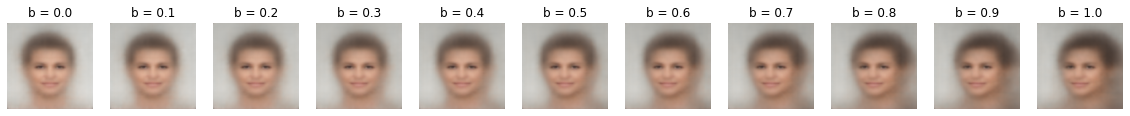

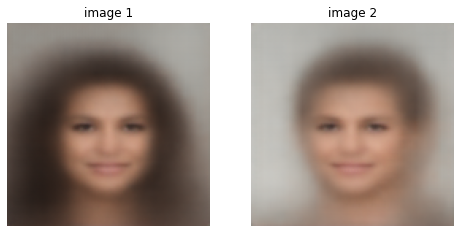

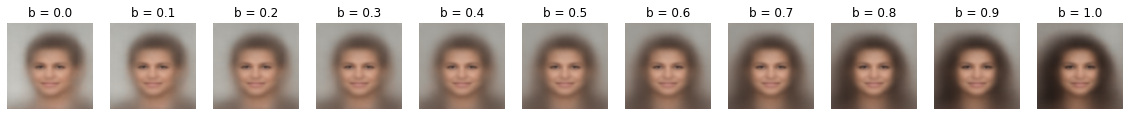

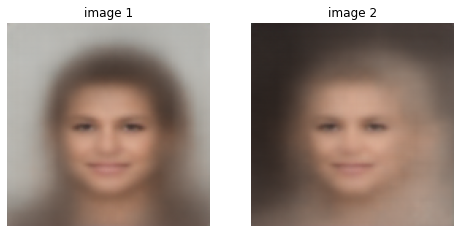

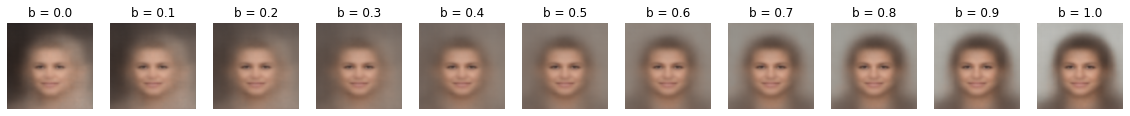

In [97]:
extrapolate_latent_domain(model1, 3)

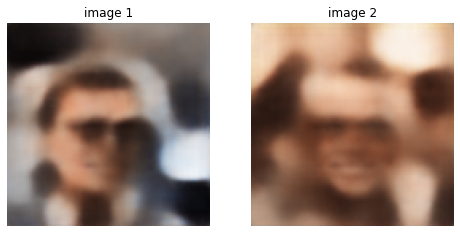

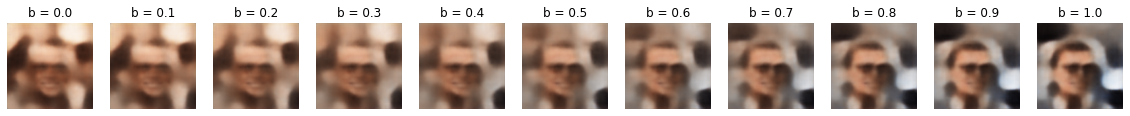

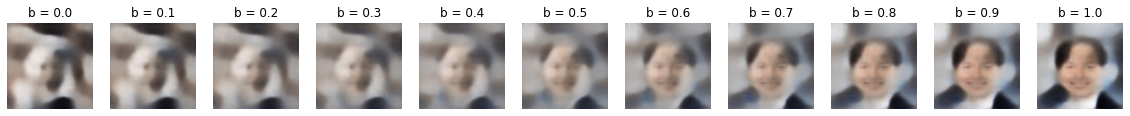

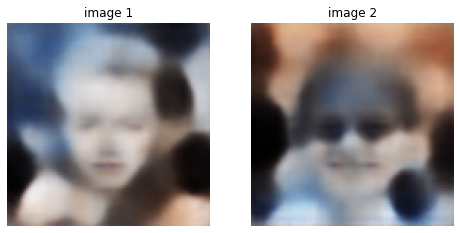

In [102]:
extrapolate_latent_domain(model_2, 50)

Extrapolating images in the latent space tends to make more sense than extrapolating in the image space, because the latent space is learned by the model to capture the important features of the data in a compact and structured form. By adding images in the latent space, we are essentially combining the learned features of the images in a meaningful way, which is likely to produce a reasonable output.

In the latent space, each element holds a feature of the image, such as the hair color or the shape of the nose. Extrapolating in the latent space is therefore likely to produce an output that is a logical combination of these features, rather than an arbitrary arrangement of pixels..